In [3]:
import numpy as np
from matplotlib import pyplot as plt
from normal_normal_model import get_samples
from covariance_CI_test import *
import pickle
from typing import List
import time
from multiprocessing import Pool
import functools

In [ ]:
num_runs = 101
num_covariate_samples = 509
num_tests = 1000

In [5]:
def print_test_collection_result(test_collection: List[CovarianceCITest]) -> None:
    if test_collection is None or len(test_collection) == 0:
        print("There is nothing in the provided test collection.")
        return
    within_CI = [test.theoretical_quantity_in_sample_CI()
                 for test in test_collection]
    
    print(test_collection[0].get_test_name() + 
          ": {}/{} ({}%) "
          .format(np.sum(within_CI), len(within_CI), 
                  np.round(100.0 * np.sum(within_CI) / len(within_CI), 2)) +
          "of the tests have the theoretical quantity within the CI.")

In [6]:
def save_test_collection(test_collection: List[CovarianceCITest]) -> None:
    if test_collection is None or len(test_collection) == 0:
        return
    file_name = ("../output/" + str(test_collection[0].__class__.__name__) + 
                 "_" + str(int(time.time())) + ".pickle")
    pickle_file = open(file_name, 'wb')
    pickle.dump(test_collection, pickle_file)
    
    print("The test collection is saved at " + file_name)

In [ ]:
def get_test_params() -> Dict[str, float]:
    """
    Randomly generate a set of parameters from a realistic param space
    """
    params = {
        'N': int(10 ** np.random.uniform(1.0, 3.5)),
        'mu_X': np.random.uniform(-10, 10),
        'mu_epsilon': np.random.uniform(-10, 10),
        'sigma_sq_X': np.random.uniform(0.3, 10) ** 2,
        'sigma_sq_1': np.random.uniform(0.3, 10) ** 2
    }
    params['M'] = max(int(params['N'] * np.random.uniform(0.01, 0.8)), 1)
    params['sigma_sq_2'] = (
        max((np.sqrt(params['sigma_sq_1']) * np.random.uniform(0.1, 0.99)) ** 2, 
            0.2 ** 2))
    params['r'] = (
        int(np.random.uniform(params['N'] - params['M'] + 1, params['N'] + 1)))
    params['s'] = (
        int(np.random.uniform(params['N'] - params['M'] + 1, params['N'] + 1)))
        
    return params

In [ ]:
cov_Yr_Ys_tests = []
cov_Yr_Ys_second_order_tests = []
cov_Yr_Zs_tests = []
cov_Yr_Zs_second_order_tests = []
cov_XIr_XJs_tests = []
cov_V1_V2_tests = []

cov_test_collections = [
    cov_Yr_Ys_tests, cov_Yr_Ys_second_order_tests,
    cov_Yr_Zs_tests, cov_Yr_Zs_second_order_tests,
    cov_XIr_XJs_tests, cov_V1_V2_tests]

for num_test in range(0, num_tests):
    try:
        # Sample the parameters from a realistic parameter space
        params = get_test_params()
        N = params['N']
        M = params['M']
        mu_X = params['mu_X']
        mu_epsilon = params['mu_epsilon']
        sigma_sq_X = params['sigma_sq_X']
        sigma_sq_1 = params['sigma_sq_1']
        sigma_sq_2 = params['sigma_sq_2']
        r = params['r']
        s = params['s']
        
        # Prepare a test
        cov_Yr_Ys_test = CovYrYsCITest(r, s, N, sigma_sq_X, sigma_sq_1=sigma_sq_1)
        cov_Yr_Ys_second_order_test = CovYrYsSecondOrderCITest(r, s, N, sigma_sq_X, sigma_sq_1=sigma_sq_1)
        cov_Yr_Zs_test = CovYrZsCITest(r, s, sigma_sq_X, sigma_sq_1, sigma_sq_2, N)
        cov_Yr_Zs_second_order_test = CovYrZsSecondOrderCITest(r, s, sigma_sq_X, sigma_sq_1, sigma_sq_2, N)
        cov_XIr_XJs_test = CovXIrXJsCITest(r, s, sigma_sq_X, sigma_sq_1, sigma_sq_2, N)
        cov_V1_V2_test = CovV1V2CITest(sigma_sq_X, sigma_sq_1, sigma_sq_2, N, M)
        
        # Arrange the covariance tests IN THE SAME ORDER as that in the collections
        cov_tests = [cov_Yr_Ys_test, cov_Yr_Ys_second_order_test, 
                     cov_Yr_Zs_test, cov_Yr_Zs_second_order_test,
                     cov_XIr_XJs_test, cov_V1_V2_test]

        for num_covariate_sample in range(0, num_covariate_samples):
            print("Test {}/{} (N={}, M={}): calculating sample {}/{}...      "
                  .format(num_test+1, num_tests, N, M,
                          num_covariate_sample+1, num_covariate_samples), 
                  end='\r')

            # Generate samples from multiple runs to obtain one
            # covariate sample for each pair of r.v. we are intersted in
            samples = get_samples(
                num_runs, N, M, mu_X, mu_epsilon, 
                sigma_sq_X, sigma_sq_1, sigma_sq_2,
                verbose=False, r=r, s=s)

            for test in cov_tests:
                test.add_sample(samples)
        
        # Once a test is completed (i.e. we collected enough covariate
        # samples), we added them to the corresponding, existing
        # collection of tests
        for (cov_test, cov_test_collection) in \
            [(cov_tests[i], cov_test_collections[i]) for i in range(0, len(cov_tests))]:
            cov_test_collection.append(cov_test)
        
    except KeyboardInterrupt:
        # Breaking the for loop is sufficient, as we want to
        # analyse the results accumulated so far
        break

for cov_test_collection in cov_test_collections:
    try:
        print_test_collection_result(cov_test_collection)
    except KeyboardInterrupt:
        print("{}: Skipped.".format(cov_test_collection[0].get_test_name()))
    save_test_collection(cov_test_collection)

# TODO: Save the tests as a pickle for future reference. https://www.thoughtco.com/using-pickle-to-save-objects-2813661
# TODO: Convert this to a callable program https://stackabuse.com/command-line-arguments-in-python/

In [14]:
for cov_test_collection in cov_test_collections:
    try:
        print_test_collection_result(cov_test_collection)
    except KeyboardInterrupt:
        print("{}: Skipped.".format(cov_test_collection[0].get_test_name()))
    save_test_collection(cov_test_collection)

Cov(Y_(r), Y_(s)): 199/199 (100.0%) of the tests have the theoretical quantity within the CI.
The test collection is saved at ../output/CovYrYsCITest_1576745780.pickle
Cov(Y_(r), Y_(s)) - 2nd order: 199/199 (100.0%) of the tests have the theoretical quantity within the CI.
The test collection is saved at ../output/CovYrYsSecondOrderCITest_1576745783.pickle
Cov(Y_(r), Z_(s)): 198/199 (99.5%) of the tests have the theoretical quantity within the CI.
The test collection is saved at ../output/CovYrZsCITest_1576745783.pickle
Cov(Y_(r), Z_(s)) - second order: 198/199 (99.5%) of the tests have the theoretical quantity within the CI.
The test collection is saved at ../output/CovYrZsSecondOrderCITest_1576745785.pickle
Cov(X_I(r), X_J(s)): 186/199 (93.47%) of the tests have the theoretical quantity within the CI.
The test collection is saved at ../output/CovXIrXJsCITest_1576745786.pickle
Cov(V1, V2): Skipped.
The test collection is saved at ../output/CovV1V2CITest_1576745792.pickle


In [ ]:
for test in cov_XIr_XJs_tests:
    if not test.theoretical_quantity_in_sample_CI():
        print(test.N, test.r, test.s, np.round(test.sigma_sq_X, 4), np.round(test.sigma_sq_1, 4), "\t",
              test.theoretical_quantity(),
              test.get_sample_CI())

In [14]:
import pickle
import os
# import rulu

def find_all_tests_in_same_category(test, in_dir='../output'):
    """
    Retrieve all tests in `in_dir` that is of the same type as the specified `test`
    """
    
    def get_tests_from_pickle_file(file_path):
        filehandler = open(file_path, 'rb')
        return pickle.load(filehandler)
    
    tests_pickle_fps = [
        os.path.join(in_dir, file)
        for file in os.listdir(in_dir) 
        if str(test.__class__.__name__) in file]
    
    print(tests_pickle_fps_pickle_fps)
    
    return [test for tests in map(get_tests_from_pickle_file, tests_pickle_fps)
            for test in tests]

test_example = CovV1V2CITest()
examples = find_all_tests_in_same_category(test_example)

print_test_collection_result(examples)


['../output/CovV1V2CITest_1576745632.pickle', '../output/CovV1V2CITest_1576745792.pickle', '../output/CovV1V2CITest_1577236948.pickle', '../output/CovV1V2CITest_1576658892.pickle', '../output/CovV1V2CITest_1576658922.pickle']


ModuleNotFoundError: No module named 'rulu'

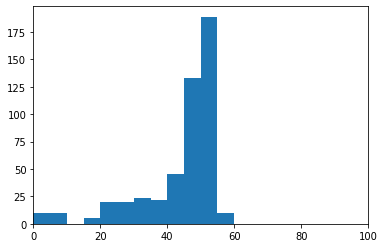

In [9]:
import scipy
pcts = [test.theoretical_quantity_sample_percentile() for test in examples]

plt.hist(pcts, bins=np.arange(0, 100, 5))
plt.xlim(0, 100)
# plt.ylim(0, 30)
plt.show()


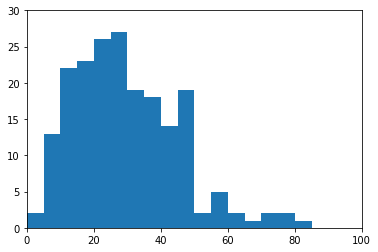

In [13]:
import scipy
pcts = [scipy.stats.percentileofscore(test.samples, test.theoretical_quantity())
    for test in cov_Yr_Zs_tests]

plt.hist(pcts, bins=np.arange(0, 100, 5))
plt.xlim(0, 100)
plt.ylim(0, 30)
plt.show()

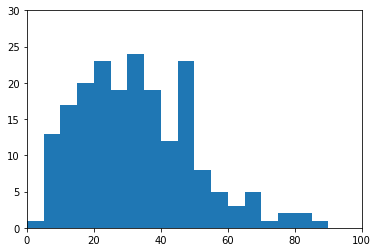

In [12]:
import scipy
pcts = [scipy.stats.percentileofscore(test.samples, test.theoretical_quantity())
    for test in cov_Yr_Zs_second_order_tests]

plt.hist(pcts, bins=np.arange(0, 100, 5))
plt.xlim(0, 100)
plt.ylim(0, 30)
plt.show()

In [ ]:
# N = 500
# M = 100
# mu_X = 0
# mu_epsilon = 0
# sigma_sq_X = 1.5**2
# sigma_sq_1 = 1.1**2
# sigma_sq_2 = 0.6**2

# r = 450
# s = 485

In [ ]:
from multiprocessing import Pool
import functools

n_bootstraps = 1000

def get_bootstrap_mean_samples(test, n_bootstraps):
    bootstraps = []
    for i in range(0, n_bootstraps):
        bootstraps.append(
            np.mean(np.random.choice(test.samples, len(test.samples), replace=True))
        )
    return bootstraps


def get_bootstrap_t_mean_samples(test, n_bootstraps):
    initial_mean = np.mean(test.samples)
    t_samples = []
    for i in range(0, n_bootstraps):
        bootstrap_set = np.random.choice(test.samples, len(test.samples), replace=True)
        t_samples.append(
            (np.mean(bootstrap_set) - initial_mean) / (np.std(bootstrap_set) / np.sqrt(bootstrap_set.shape[0]))
        )
    return t_samples

bootstrap_mean_samples_getter = functools.partial(get_bootstrap_mean_samples, n_bootstraps=n_bootstraps)
bootstrap_t_mean_samples_getter = functools.partial(get_bootstrap_t_mean_samples, n_bootstraps=n_bootstraps)

with Pool(4) as p:
    bootstrap_samples = p.map(bootstrap_mean_samples_getter, cov_Yr_Ys_second_order_tests)
    bootstrap_t_samples = p.map(bootstrap_t_mean_samples_getter, cov_Yr_Ys_second_order_tests)

for i in range(0, len(cov_Yr_Ys_second_order_tests)):
#     print([np.round(np.percentile(bootstrap_samples[i], 2.5), 3), 
#            np.round(np.percentile(bootstrap_samples[i], 97.5), 4)], end="\t")

    print((cov_Yr_Ys_second_order_tests[i].theoretical_quantity() > (
               np.mean(cov_Yr_Ys_second_order_tests[i].samples) - 
               np.percentile(bootstrap_t_samples[i], 97.5) * 
               np.std(cov_Yr_Ys_second_order_tests[i].samples) / 
               np.sqrt(len(cov_Yr_Ys_second_order_tests[i].samples))
           )) and
           (cov_Yr_Ys_second_order_tests[i].theoretical_quantity() < (
               np.mean(cov_Yr_Ys_second_order_tests[i].samples) - 
               np.percentile(bootstrap_t_samples[i], 2.5) * 
               np.std(cov_Yr_Ys_second_order_tests[i].samples) / 
               np.sqrt(len(cov_Yr_Ys_second_order_tests[i].samples))
           )))